In [3]:
import numpy as np

import torch
from torchvision.transforms import ToTensor
from torch import no_grad
from torchvision import datasets
import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss, MaxPool2d, Flatten, Sequential, ReLU)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from qiskit import *
from qiskit import transpile, assemble, IBMQ
from qiskit.visualization import *
from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector
import qiskit.providers.fake_provider as fake
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator, QasmSimulator

import matplotlib.pyplot as plt

In [4]:
provider = IBMQ.load_account()

configrc.store_credentials:WARNING:2022-07-15 15:13:12,762: Credentials already present. Set overwrite=True to overwrite.


In [5]:
# Declare Quantum instance
noisy_backend = provider.get_backend('ibmq_manila')
backend_sim = AerSimulator.from_backend(noisy_backend)

qi = QuantumInstance(backend_sim)

print(backend_sim)

aer_simulator(ibmq_manila)


In [6]:
### Training and test data downloaded from FashionMNIST and transformed into tensors ###
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

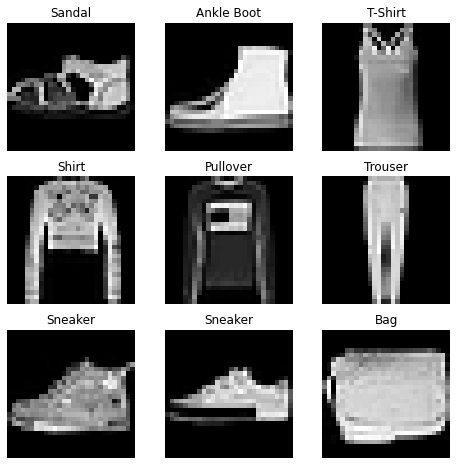

In [7]:
### Inspecting the images in the training data set with their labels ###
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [8]:
### Load training data into Torch DataLoader ###
X_train = training_data
n_samples = 500
batch_size = 64

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples],
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# A torch dataloader is defined with filtered data
train_loader = DataLoader(X_train, batch_size=64, shuffle=True)

In [9]:
# Load test data into Torch DataLoader
X_test = test_data

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(np.where(X_test.targets == 0)[0][:n_samples],
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=64, shuffle=True)

# Manual Composition of the Feature Map & Ansatz

In [12]:
pi = np.pi
feature_dim = 2
reps = 2
duplicates = 3 # only use odd integers here
feature_map_circuit = QuantumCircuit(feature_dim, name=f'feature_map_circuit, duplicates = {duplicates}')
x = ParameterVector('x', feature_dim * reps)

for i in range(reps):
    for j in range(feature_dim):
        for k in range(duplicates):
            feature_map_circuit.h(j)

    for m in range(duplicates):
        feature_map_circuit.p(2.0*x[0], 0)
        feature_map_circuit.p(2.0*x[1], 1)

    for m in range(duplicates):
        feature_map_circuit.cnot(0, 1)

    for m in range(duplicates):
        feature_map_circuit.p(2.0*(pi - x[0])*(pi - x[1]), 1)

    for m in range(duplicates):
        feature_map_circuit.cnot(0, 1)

feature_map_circuit.draw()

┌───┐┌───┐┌───┐┌─────────────┐┌─────────────┐┌─────────────┐          »
q_0: ┤ H ├┤ H ├┤ H ├┤ P(2.0*x[0]) ├┤ P(2.0*x[0]) ├┤ P(2.0*x[0]) ├──■────■──»
     ├───┤├───┤├───┤├─────────────┤├─────────────┤├─────────────┤┌─┴─┐┌─┴─┐»
q_1: ┤ H ├┤ H ├┤ H ├┤ P(2.0*x[1]) ├┤ P(2.0*x[1]) ├┤ P(2.0*x[1]) ├┤ X ├┤ X ├»
     └───┘└───┘└───┘└─────────────┘└─────────────┘└─────────────┘└───┘└───┘»
«                                                                          »
«q_0: ──■──────────────────────────────────────────────────────────────────»
«     ┌─┴─┐┌──────────────────────────────┐┌──────────────────────────────┐»
«q_1: ┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ P(2.0*(π - x[0])*(π - x[1])) ├»
«     └───┘└──────────────────────────────┘└──────────────────────────────┘»
«                                                    ┌───┐┌───┐┌───┐»
«q_0: ──────────────────────────────────■────■────■──┤ H ├┤ H ├┤ H ├»
«     ┌──────────────────────────────┐┌─┴─┐┌─┴─┐┌─┴─┐├───┤├───┤├───┤»
«q_1: ┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ X ├┤ X ├┤ H ├┤ H ├┤ H ├»
«     └──────────────────────────────┘└───┘└───┘└───┘└───┘└───┘└───┘»
«     ┌─────────────┐┌─────────────┐┌─────────────┐               »
«q_0: ┤ P(2.0*x[0]) ├┤ P(2.0*x[0]) ├┤ P(2.0*x[0]) ├──■────■────■──»
«     ├─────────────┤├─────────────┤├─────────────┤┌─┴─┐┌─┴─┐┌─┴─┐»
«q_1: ┤ P(2.0*x[1]) ├┤ P(2.0*x[1]) ├┤ P(2.0*x[1]) ├┤ X ├┤ X ├┤ X ├»
«     └─────────────┘└─────────────┘└─────────────┘└───┘└───┘└───┘»
«                                                                     »
«q_0: ────────────────────────────────────────────────────────────────»
«     ┌──────────────────────────────┐┌──────────────────────────────┐»
«q_1: ┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ P(2.0*(π - x[0])*(π - x[1])) ├»
«     └──────────────────────────────┘└──────────────────────────────┘»
«                                                    
«q_0: ──────────────────────────────────■────■────■──
«     ┌──────────────────────────────┐┌─┴─┐┌─┴─┐┌─┴─┐
«q_1: ┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ X ├┤ X ├
«     └──────────────────────────────┘└───┘└───┘└───┘

In [13]:
num_qubits = 2
ansatz_circuit = QuantumCircuit(num_qubits, name=f'ansatz_circuit, duplicates = {duplicates}')
reps = 1
params = ParameterVector('θ', num_qubits + num_qubits * reps)
counter = 0

for i in range(num_qubits):
    for n in range(duplicates):
        ansatz_circuit.ry(params[counter], i)
    counter += 1

for j in range(reps):
    for k in range(num_qubits-1):
        for n in range(duplicates):
            ansatz_circuit.cnot(k, k+1)
    for m in range(num_qubits):
        for n in range(duplicates):
            ansatz_circuit.ry(params[counter], m)
        counter += 1

ansatz_circuit.draw()

┌──────────┐┌──────────┐┌──────────┐               ┌──────────┐»
q_0: ┤ Ry(θ[0]) ├┤ Ry(θ[0]) ├┤ Ry(θ[0]) ├──■────■────■──┤ Ry(θ[2]) ├»
     ├──────────┤├──────────┤├──────────┤┌─┴─┐┌─┴─┐┌─┴─┐├──────────┤»
q_1: ┤ Ry(θ[1]) ├┤ Ry(θ[1]) ├┤ Ry(θ[1]) ├┤ X ├┤ X ├┤ X ├┤ Ry(θ[3]) ├»
     └──────────┘└──────────┘└──────────┘└───┘└───┘└───┘└──────────┘»
«     ┌──────────┐┌──────────┐
«q_0: ┤ Ry(θ[2]) ├┤ Ry(θ[2]) ├
«     ├──────────┤├──────────┤
«q_1: ┤ Ry(θ[3]) ├┤ Ry(θ[3]) ├
«     └──────────┘└──────────┘

In [14]:
qnn2 = TwoLayerQNN(2, feature_map_circuit, ansatz_circuit, input_gradients=True,
                   exp_val=AerPauliExpectation(), quantum_instance=qi)
print(qnn2.operator)


ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌─────────────────────────────────────────────────┐»
  q_0: ┤0                                                ├»
       │  feature_map_circuit, duplicates = 3(x[0],x[1]) │»
  q_1: ┤1                                                ├»
       └─────────────────────────────────────────────────┘»
  «     ┌──────────────────────────────────────────────────────┐
  «q_0: ┤0                                                     ├
  «     │  ansatz_circuit, duplicates = 3(θ[0],θ[1],θ[2],θ[3]) │
  «q_1: ┤1                                                     ├
  «     └──────────────────────────────────────────────────────┘
  )
])


In [15]:
### Torch NN module from Qiskit ###
class Net(Module):

    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)         # 2-dimensional input to QNN
        # Apply torch connector, weights chosen
        self.qnn = TorchConnector(qnn2)
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)
        # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return torch.cat((x, 1 - x), -1)

In [16]:
### Model trained and the loss computed ###
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))


Training [5%]	Loss: -0.6677
Training [10%]	Loss: -0.9524
Training [15%]	Loss: -1.0813
Training [20%]	Loss: -1.1765
Training [25%]	Loss: -1.2248
Training [30%]	Loss: -1.2788
Training [35%]	Loss: -1.3261
Training [40%]	Loss: -1.3720
Training [45%]	Loss: -1.4064
Training [50%]	Loss: -1.4530
Training [55%]	Loss: -1.4836
Training [60%]	Loss: -1.5043
Training [65%]	Loss: -1.5388
Training [70%]	Loss: -1.5600
Training [75%]	Loss: -1.5863
Training [80%]	Loss: -1.6049
Training [85%]	Loss: -1.6231
Training [90%]	Loss: -1.6406
Training [95%]	Loss: -1.6658
Training [100%]	Loss: -1.6816


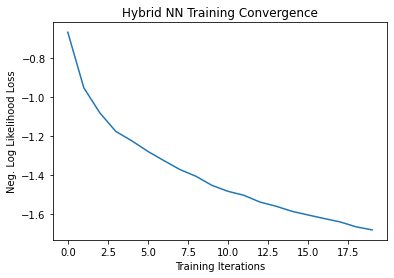

In [17]:
### Loss convergence plotted ###
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg. Log Likelihood Loss')
plt.show()

In [18]:
torch.save(model.state_dict(
), 'Models/d3ZZ_d3RealAmp.pth')

In [19]:
### Model evaluated ###
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        (correct / len(test_loader) / batch_size) * 100))


Performance on test data:
	Loss: -1.6806
	Accuracy: 96.4%


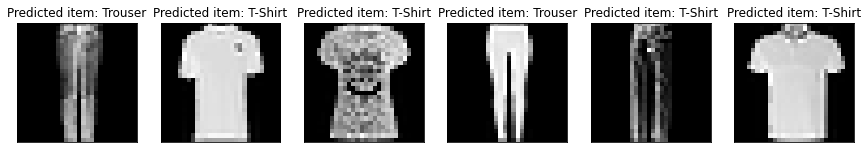

In [20]:
### Predicted images displayed. Either T-shirt or Trouser ###
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(15, 5))

model.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        if pred.item() == 0:
            axes[count].set_title('Predicted item: T-Shirt')
        elif pred.item() == 1:
            axes[count].set_title('Predicted item: Trouser')
        count += 1
